## Investigating the Impact of Convolutional Kernel Sizes on EEG Classification Performance

### Experiment Summary:

**This experiment aims to explore the influence of different convolutional kernel sizes on the performance of EEG classification models. The experiment utilizes a sequential EEG model architecture with two convolutional layers followed by dense layers. The kernel sizes of the convolutional layers are varied to observe their effects on classification accuracy.**

A total of 16 experiments are conducted based on the provided configurations.

Each experiment employs 5-fold cross-validation to assess the model performance robustly. Multiple folds are created, and the model is trained and evaluated on each fold. Training histories, including loss, accuracy, validation loss, and validation accuracy, are logged for analysis.

The experiment systematically tests various combinations of convolutional kernel sizes, iterating through different values for both convolutional layers. The models are compiled with the Adam optimizer and trained for a fixed number of epochs.

The results, including fold accuracies and average accuracy across all folds, are recorded(logged) and analyzed. Additionally, loss and accuracy plots are generated to visualize the training progress and performance of each model configuration.

By examining the impact of different convolutional kernel sizes, this experiment aims to provide insights into the optimal configuration for EEG classification tasks, aiding in the development of more accurate and efficient models for EEG analysis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ED_exeriments/ED_CNN_E03
%ls

/content/drive/MyDrive/ED_exeriments/ED_CNN_03


## Import libraries

In [ ]:
import sys
import os
import logging


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


# from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


In [ ]:
## seed
np.random.seed(2023)

### Reading CSV data

In [ ]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/main/Epileptic%20Seizure%20Recognition.csv')
raw_data.shape

(11500, 180)

In [ ]:
raw_data

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [ ]:
raw_data.values.shape

(11500, 180)

In [ ]:
data = raw_data.values # converted to an numpy array
data = data[:, 1:] # discarding the Unnamed Column
data.shape

(11500, 179)

In [ ]:
# let's see how it looks like
data

array([[135, 190, 229, ..., -83, -51, 4],
       [386, 382, 356, ..., 143, 129, 1],
       [-32, -39, -47, ..., -35, -36, 5],
       ...,
       [14, 6, -13, ..., -1, -8, 5],
       [-40, -25, -9, ..., 59, 55, 3],
       [29, 41, 57, ..., 2, 20, 4]], dtype=object)

In [ ]:
# let's see the type
type(data)

numpy.ndarray

### Classifying data categories as it mentioned in the paper

In [ ]:
df_1 = data[data[:, -1] == 1].astype(int) # seizure
df_2 = data[data[:, -1] == 2].astype(int)
df_3 = data[data[:, -1] == 3].astype(int)
df_4 = data[data[:, -1] == 4].astype(int)
df_5 = data[data[:, -1] == 5].astype(int)

# let's print the shape of each category
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


## Let's plot some random data points from every category

In [ ]:
def visualize_eeg(number_of_datapoints):
    for i in (np.random.randint(0, 2300, number_of_datapoints)):
        plt.plot(df_1[i, :], 'r-', label='df_1')
        plt.plot(df_2[i, :], 'g-', label='df_2')
        plt.plot(df_3[i, :], 'k-', label='df_3')
        plt.plot(df_4[i, :], 'b-', label='df_4')
        plt.plot(df_5[i, :], 'm-', label='df_5')
        plt.legend()
        plt.title(f'visualizing {i} th data point')
        plt.xlabel('time')
        plt.ylabel('aplitude(uV)')
        plt.show()

### Visualizing all categories in single figure

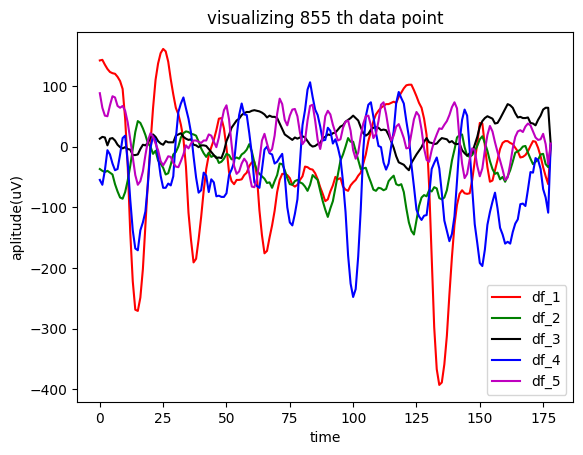

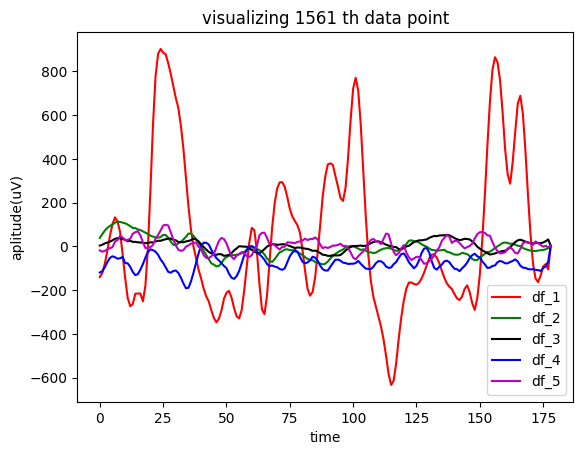

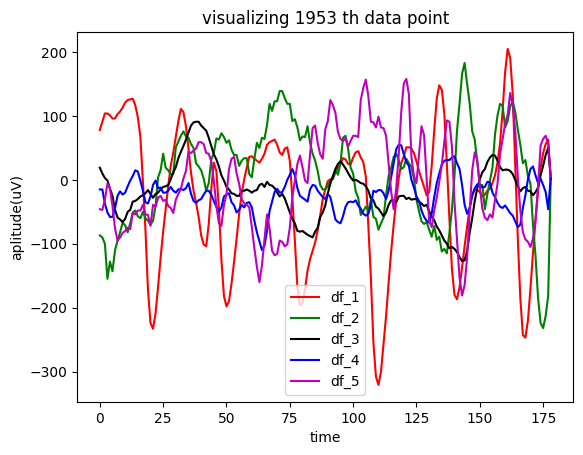

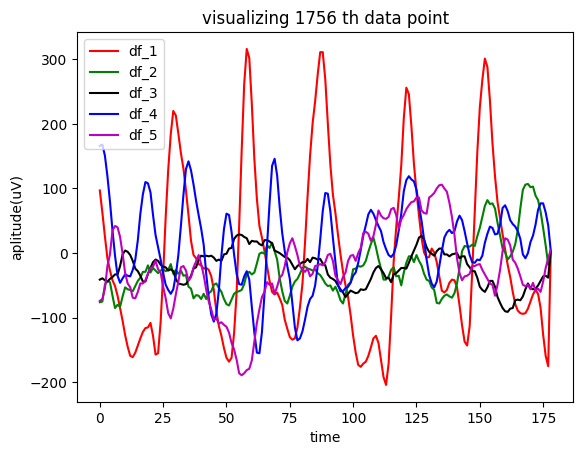

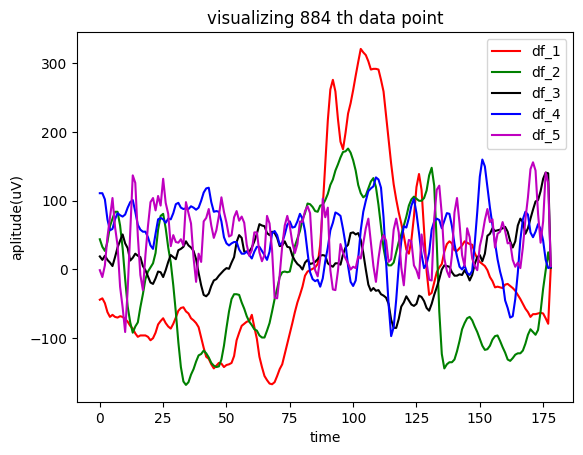

In [ ]:
### all categories
visualize_eeg(5)

## Converting data into integer and making the data into seizure and non-seizure cateogry

In [ ]:
all_data = data.copy().astype('int')

In [ ]:
all_data

array([[135, 190, 229, ..., -83, -51,   4],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   5],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   5],
       [-40, -25,  -9, ...,  59,  55,   3],
       [ 29,  41,  57, ...,   2,  20,   4]])

In [ ]:
all_data[:, -1] = np.where(all_data[:, -1] != 1, 0, all_data[:, -1])
all_data

array([[135, 190, 229, ..., -83, -51,   0],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   0],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   0],
       [-40, -25,  -9, ...,  59,  55,   0],
       [ 29,  41,  57, ...,   2,  20,   0]])

In [ ]:
print(len(all_data[all_data[:, -1] == 1]))
print(len(all_data[all_data[:, -1] == 0]))

2300
9200


## Plot functions

### function to plot loss curve of the
- (training and validation loss) and
- (training and validation accuracy)


In [ ]:
def plot_loss_accuracy(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(history.history['loss'], 'b-')
    ax[0].plot(history.history['val_loss'], 'r-')
    ax[0].legend(['train_loss', 'val_loss'])
    ax[0].set_title('Loss curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss %')

    ax[1].plot(history.history['accuracy'], 'b-')
    ax[1].plot(history.history['val_accuracy'], 'r-')
    ax[1].legend(['train_accuracy', 'val_accuracy'])
    ax[1].set_title('Accuracy curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('accuracy %')

    plt.suptitle(title)
    plt.savefig(title + '.png')

    plt.show()

In [ ]:
# Initialize StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

In [ ]:
def input_output_data(data, random_state=2023):

    X = all_data[:, :-1]
    y = all_data[:, -1]

    return X, y

X, y = input_output_data(data)

In [ ]:
def process_input(X, y, train_index, val_index):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = np.expand_dims(X_train, axis=2)
    X_val = np.expand_dims(X_val, axis=2)

    input_shape = (X_train.shape[1], 1)

    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')


    return X_train, X_val, y_train, y_val, input_shape

## Logger Setup

In [ ]:
import absl.logging
import sys
import logging
absl.logging.set_verbosity(absl.logging.ERROR)
absl.logging.set_verbosity(absl.logging.INFO)

In [ ]:
def init_logger(log_file, log_level=logging.INFO, stdout=True):
    logger = logging.getLogger()
    logger.setLevel(log_level)

    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    if stdout:
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(formatter)
        logger.addHandler(console_handler)

    return logger


## Let's experiment with the kernel size

```
kernel_sizes = [3, 4, 5, 6]

```


In [ ]:
# class eegClassifier(keras.Model):
#     def __init__(self, input_shape, ks_1, ks_2):
#         super(eegClassifier, self).__init__()

#         self.conv1 = layers.Conv1D(filters=128, kernel_size=ks_1, input_shape=input_shape)
#         self.bn_1 = BatchNormalization()
#         self.max_pool_1 = layers.MaxPooling1D(2, padding='same')

#         self.conv2 = layers.Conv1D(filters=512, kernel_size=ks_2)
#         self.bn_2 = BatchNormalization()
#         self.max_pool_2 = layers.MaxPooling1D(2, padding='same')

#         self.flatten = Flatten()

#         self.dense_1 = Dense(128)
#         self.dense_2 = Dense(32)

#         self.output_dense = Dense(1, activation='sigmoid')

#     def call(self, inputs):
#         x = self.conv1(inputs)
#         x = tf.nn.relu(self.bn_1(x))
#         x = self.max_pool_1(x)

#         x = self.conv2(x)
#         x = tf.nn.relu(self.bn_2(x))
#         x = self.max_pool_2(x)

#         x = self.flatten(x)
#         x = self.dense_1(x)
#         x = tf.nn.relu(x)
#         x = self.dense_2(x)
#         x = tf.nn.relu(x)
#         return self.output_dense(x)


In [ ]:
def create_sequential_eeg_model(input_shape, ks_1, ks_2):
    model = keras.Sequential()

    model.add(layers.Conv1D(filters=128, kernel_size=ks_1, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2, padding='same'))

    model.add(layers.Conv1D(filters=512, kernel_size=ks_2))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2, padding='same'))

    model.add(layers.Flatten())

    model.add(layers.Dense(128))
    model.add(layers.ReLU())
    model.add(layers.Dense(32))
    model.add(layers.ReLU())

    model.add(layers.Dense(1, activation='sigmoid'))

    return model



---- fold = 1 ---- conv1_ks = 3 ---- conv2_ks = 3-------

72/72 [==============================] - 0s 3ms/step - loss: 0.1537 - accuracy: 0.9748
conv1_ks=3,conv2_ks=3 Fold = 1 accuracy: 0.9747825860977173


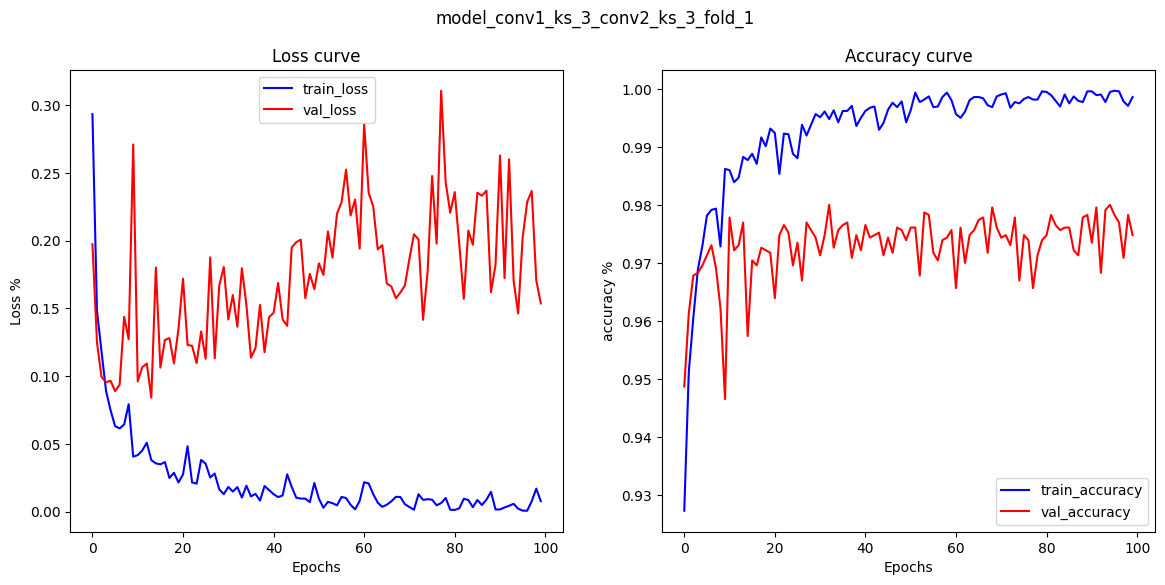



---- fold = 2 ---- conv1_ks = 3 ---- conv2_ks = 3-------

72/72 [==============================] - 0s 4ms/step - loss: 0.1974 - accuracy: 0.9748
conv1_ks=3,conv2_ks=3 Fold = 2 accuracy: 0.9747825860977173


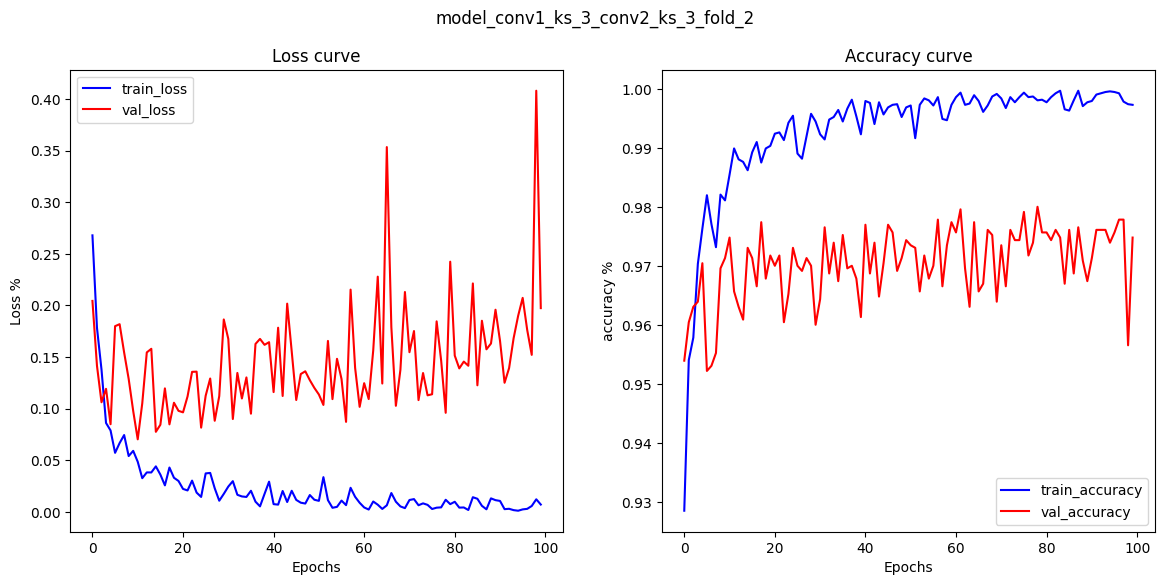



---- fold = 3 ---- conv1_ks = 3 ---- conv2_ks = 3-------

72/72 [==============================] - 0s 4ms/step - loss: 0.1963 - accuracy: 0.9774
conv1_ks=3,conv2_ks=3 Fold = 3 accuracy: 0.9773913025856018


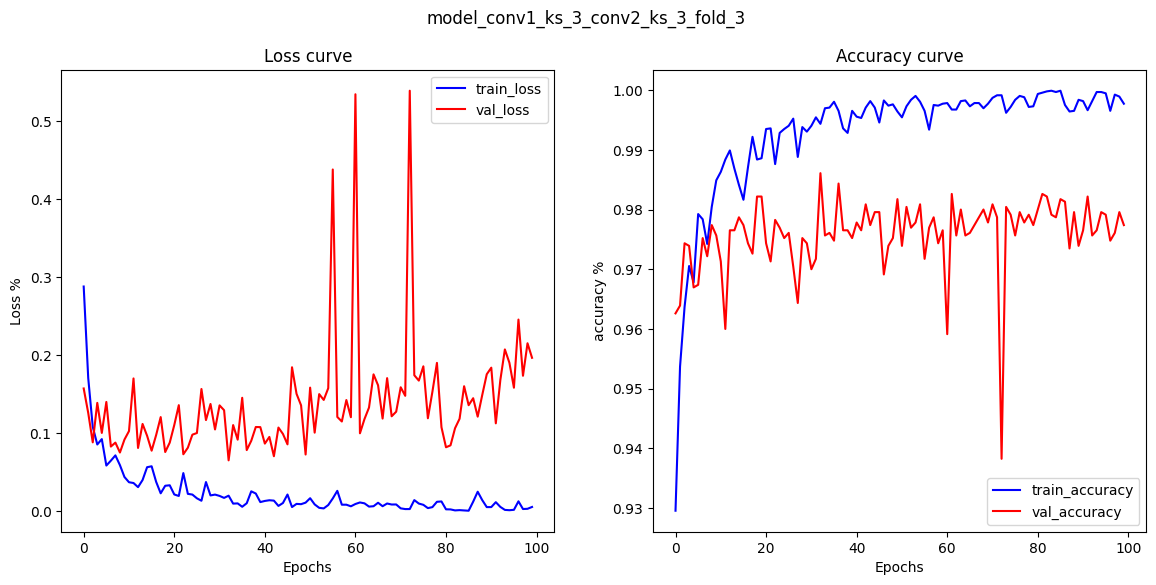



---- fold = 4 ---- conv1_ks = 3 ---- conv2_ks = 3-------

72/72 [==============================] - 0s 4ms/step - loss: 0.2076 - accuracy: 0.9670
conv1_ks=3,conv2_ks=3 Fold = 4 accuracy: 0.9669564962387085


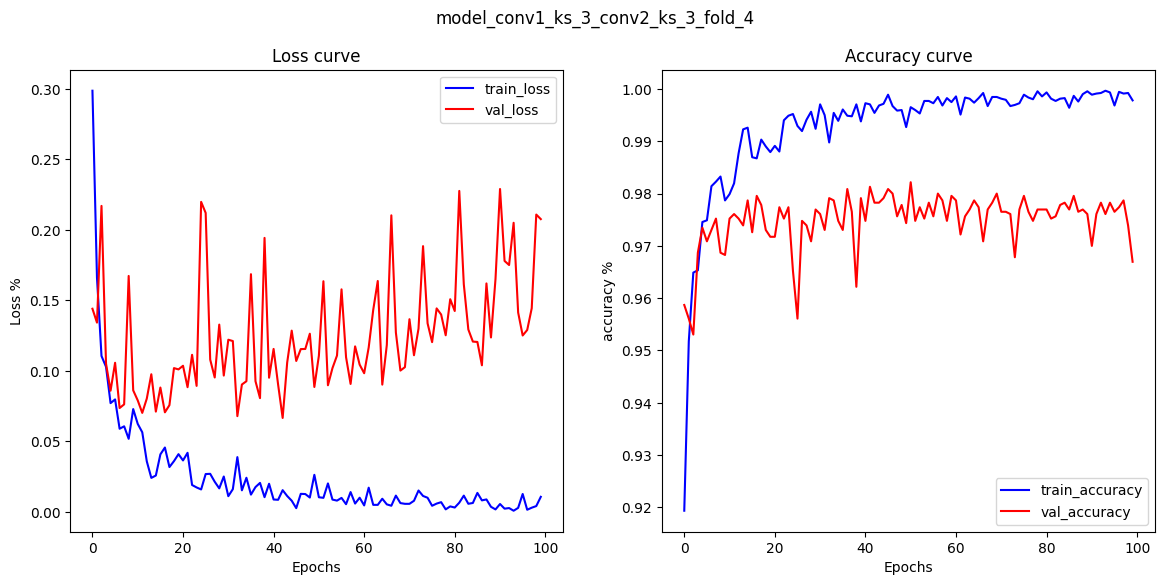



---- fold = 5 ---- conv1_ks = 3 ---- conv2_ks = 3-------

72/72 [==============================] - 0s 4ms/step - loss: 0.1250 - accuracy: 0.9830
conv1_ks=3,conv2_ks=3 Fold = 5 accuracy: 0.9830434918403625


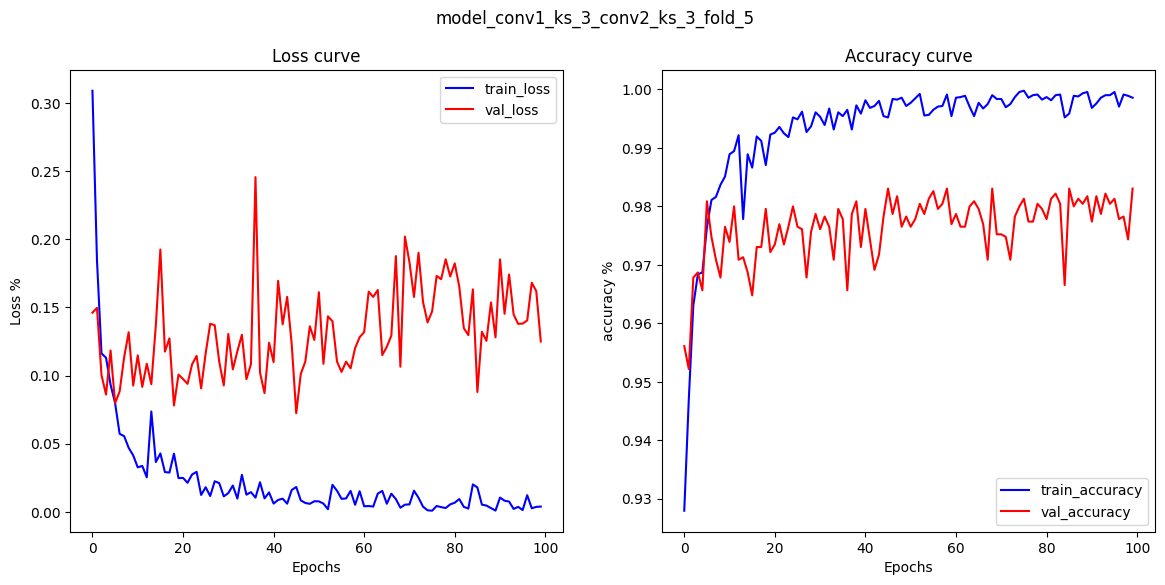

Mean Accuracy: 0.9753912925720215


---- fold = 1 ---- conv1_ks = 3 ---- conv2_ks = 4-------

72/72 [==============================] - 0s 4ms/step - loss: 0.3043 - accuracy: 0.9717
conv1_ks=3,conv2_ks=4 Fold = 1 accuracy: 0.9717391133308411


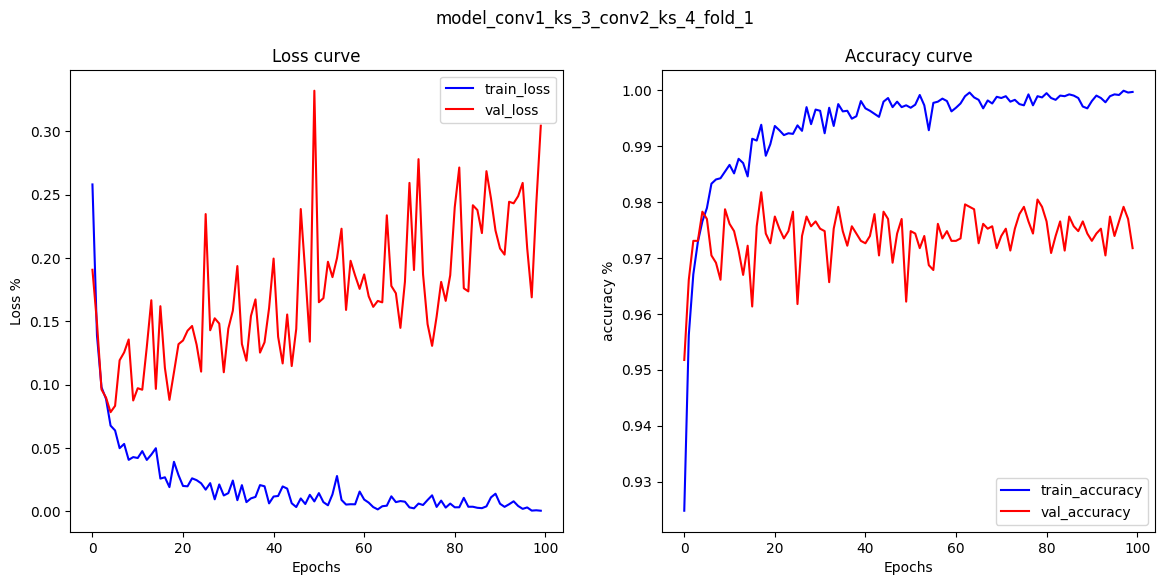



---- fold = 2 ---- conv1_ks = 3 ---- conv2_ks = 4-------

72/72 [==============================] - 0s 4ms/step - loss: 0.1871 - accuracy: 0.9704
conv1_ks=3,conv2_ks=4 Fold = 2 accuracy: 0.9704347848892212


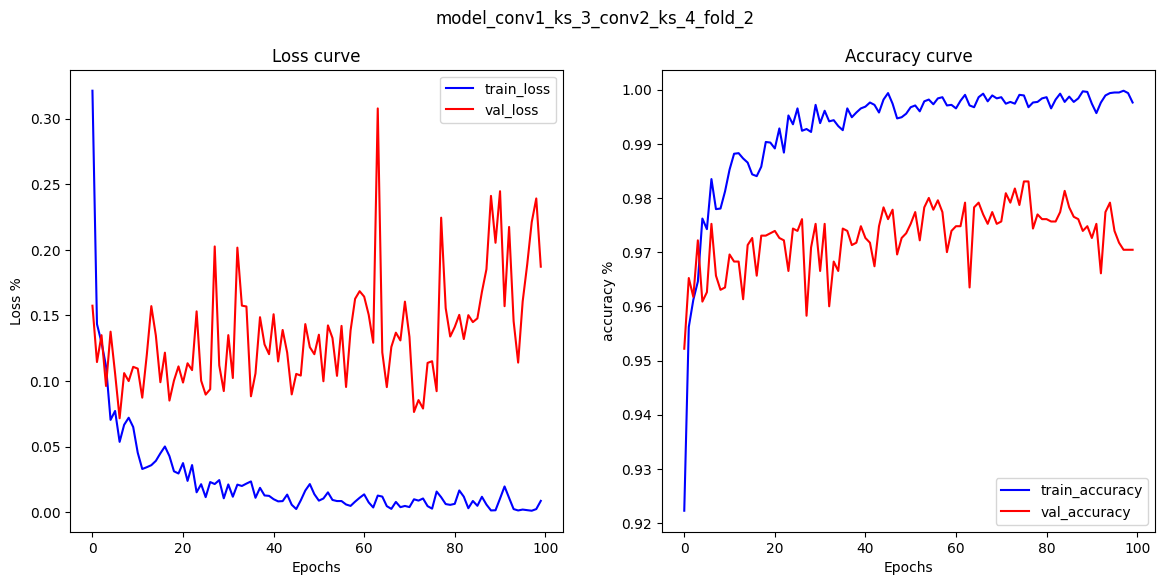



---- fold = 3 ---- conv1_ks = 3 ---- conv2_ks = 4-------

72/72 [==============================] - 0s 4ms/step - loss: 0.1477 - accuracy: 0.9761
conv1_ks=3,conv2_ks=4 Fold = 3 accuracy: 0.9760869741439819


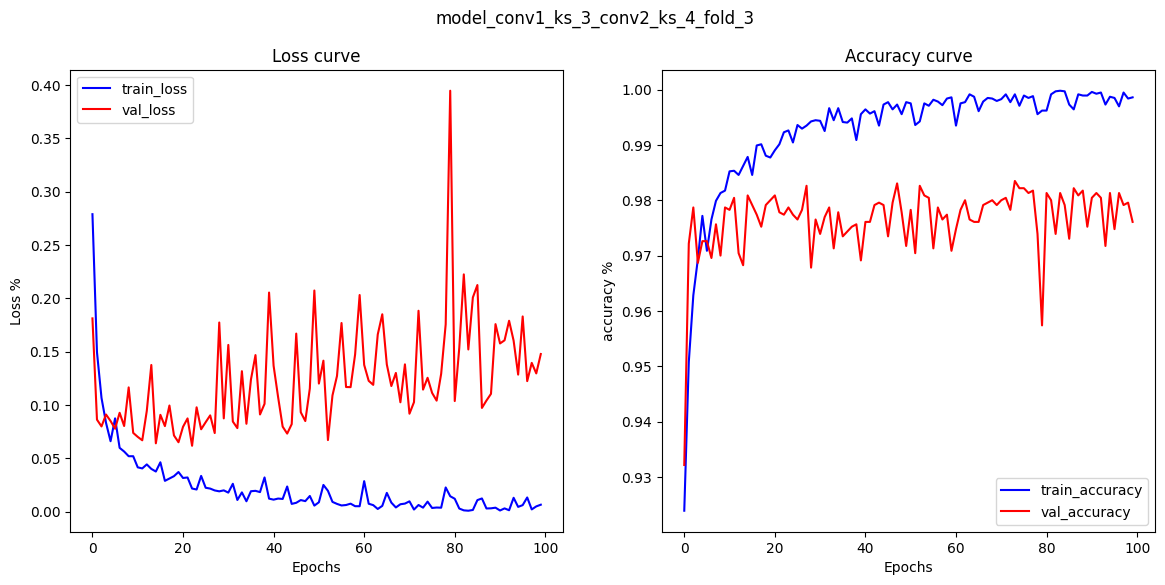



---- fold = 4 ---- conv1_ks = 3 ---- conv2_ks = 4-------

72/72 [==============================] - 0s 5ms/step - loss: 0.2098 - accuracy: 0.9739
conv1_ks=3,conv2_ks=4 Fold = 4 accuracy: 0.9739130139350891


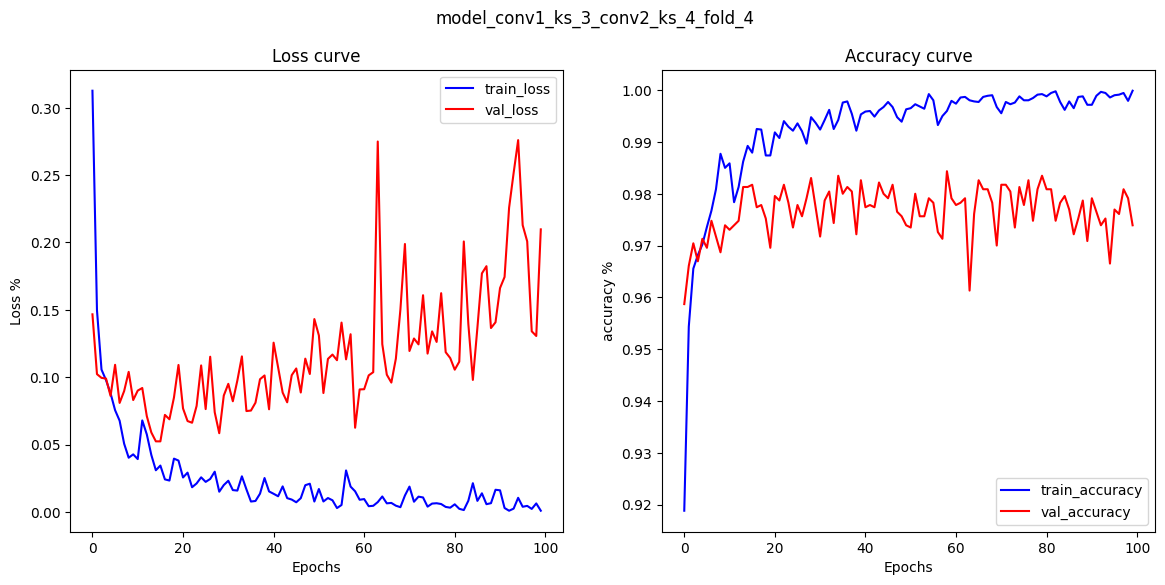



---- fold = 5 ---- conv1_ks = 3 ---- conv2_ks = 4-------

72/72 [==============================] - 0s 4ms/step - loss: 0.1684 - accuracy: 0.9752
conv1_ks=3,conv2_ks=4 Fold = 5 accuracy: 0.9752174019813538


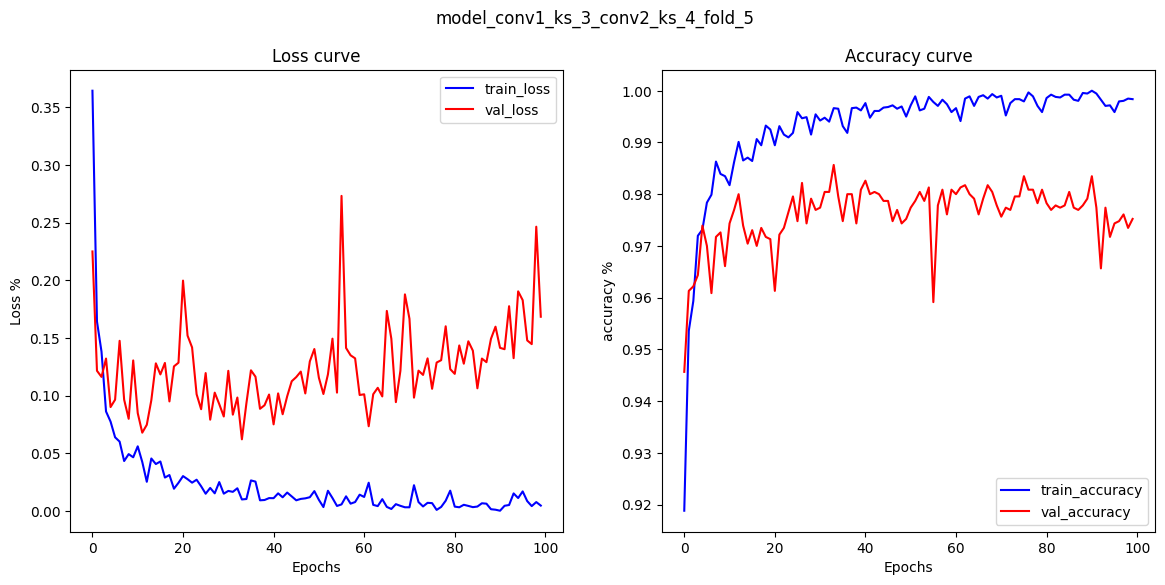

Mean Accuracy: 0.9734782576560974


---- fold = 1 ---- conv1_ks = 3 ---- conv2_ks = 5-------

72/72 [==============================] - 0s 5ms/step - loss: 0.2071 - accuracy: 0.9726
conv1_ks=3,conv2_ks=5 Fold = 1 accuracy: 0.9726086854934692


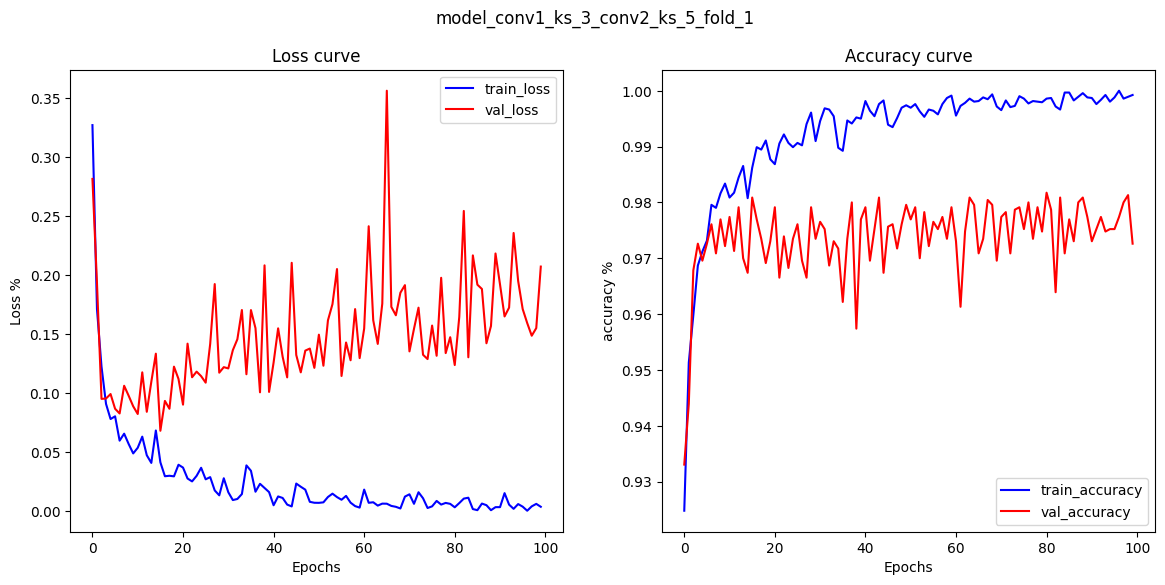



---- fold = 2 ---- conv1_ks = 3 ---- conv2_ks = 5-------

72/72 [==============================] - 0s 4ms/step - loss: 0.1958 - accuracy: 0.9696
conv1_ks=3,conv2_ks=5 Fold = 2 accuracy: 0.969565212726593


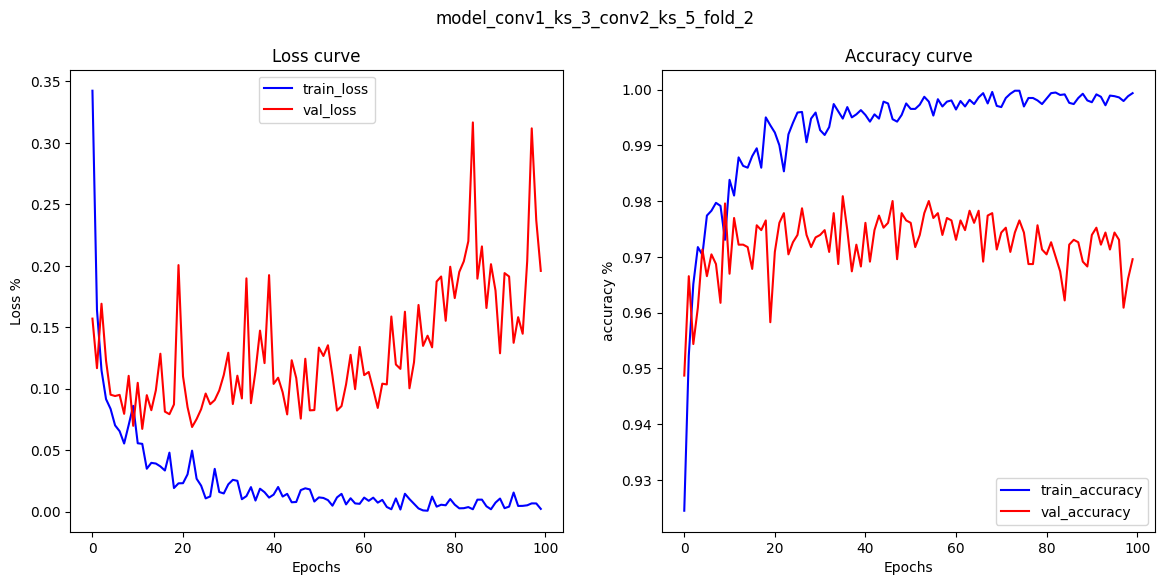



---- fold = 3 ---- conv1_ks = 3 ---- conv2_ks = 5-------

72/72 [==============================] - 0s 4ms/step - loss: 0.1141 - accuracy: 0.9826
conv1_ks=3,conv2_ks=5 Fold = 3 accuracy: 0.9826086759567261


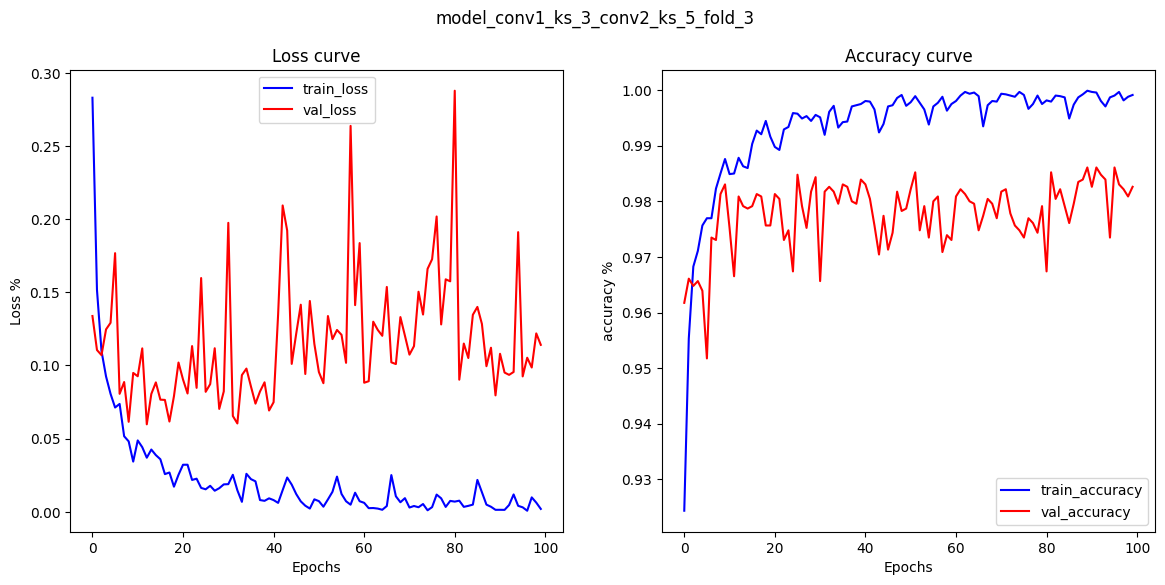



---- fold = 4 ---- conv1_ks = 3 ---- conv2_ks = 5-------

72/72 [==============================] - 0s 5ms/step - loss: 0.1757 - accuracy: 0.9796
conv1_ks=3,conv2_ks=5 Fold = 4 accuracy: 0.9795652031898499


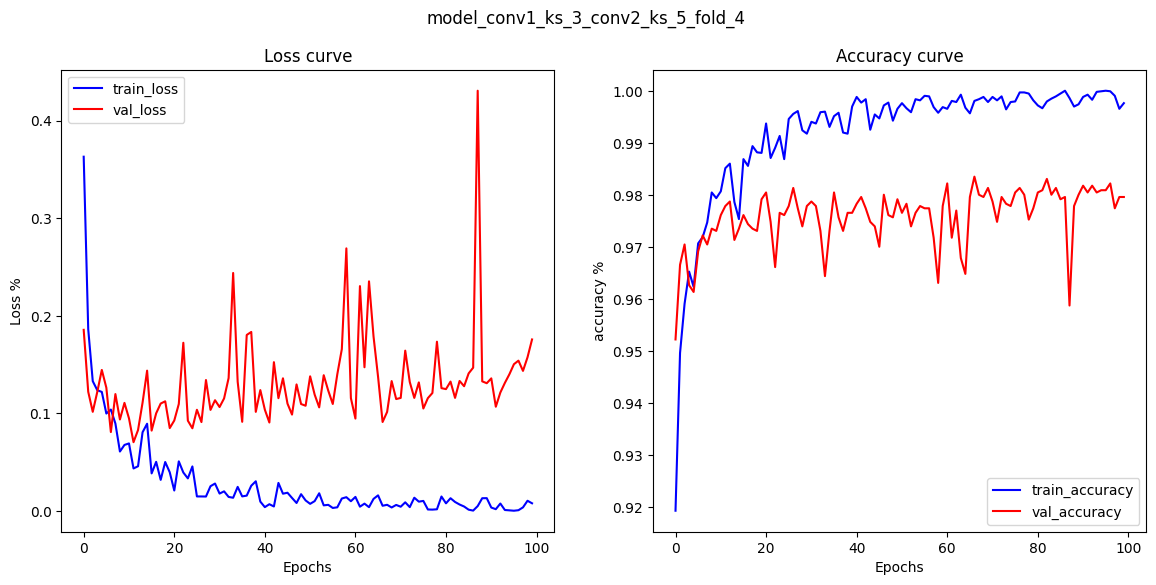



---- fold = 5 ---- conv1_ks = 3 ---- conv2_ks = 5-------

72/72 [==============================] - 0s 5ms/step - loss: 0.1663 - accuracy: 0.9761
conv1_ks=3,conv2_ks=5 Fold = 5 accuracy: 0.9760869741439819


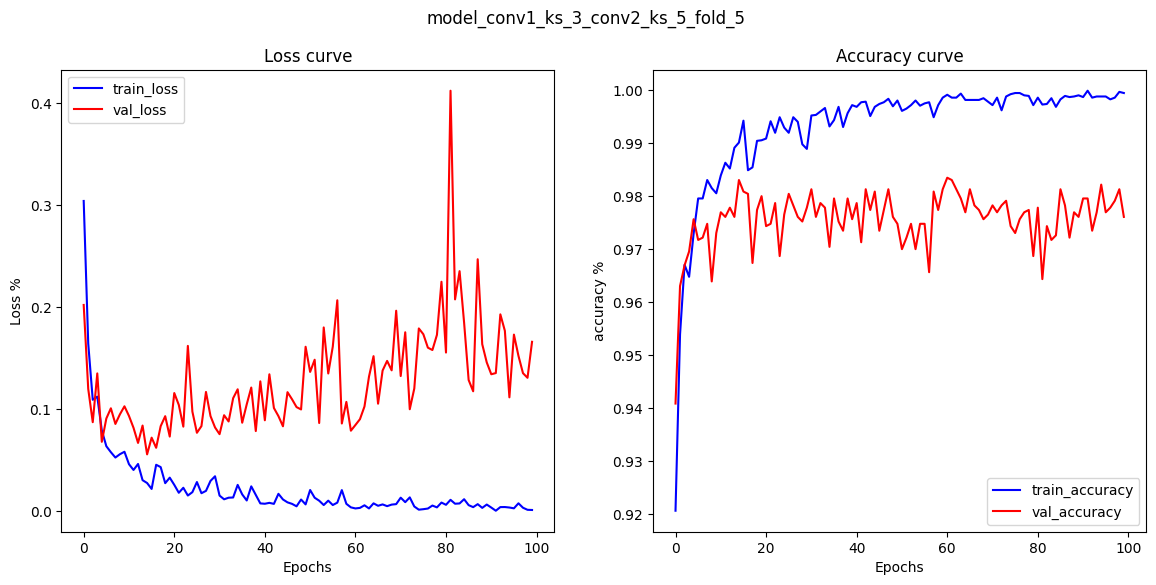

Mean Accuracy: 0.976086950302124


---- fold = 1 ---- conv1_ks = 3 ---- conv2_ks = 6-------

72/72 [==============================] - 0s 4ms/step - loss: 0.2129 - accuracy: 0.9765
conv1_ks=3,conv2_ks=6 Fold = 1 accuracy: 0.9765217304229736


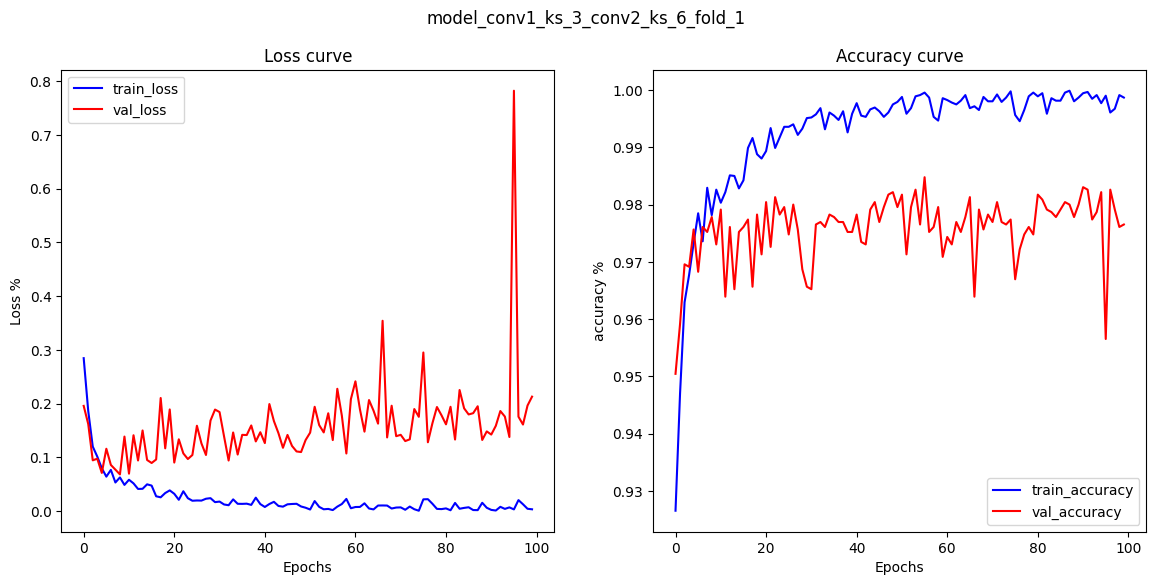



---- fold = 2 ---- conv1_ks = 3 ---- conv2_ks = 6-------

72/72 [==============================] - 0s 5ms/step - loss: 0.1590 - accuracy: 0.9730
conv1_ks=3,conv2_ks=6 Fold = 2 accuracy: 0.9730435013771057


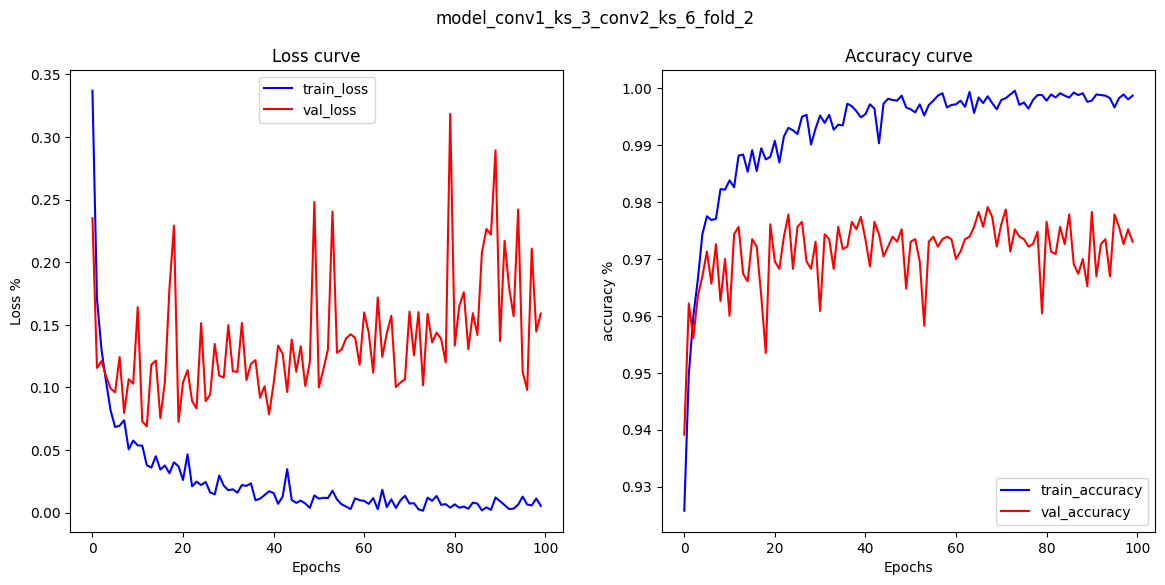



---- fold = 3 ---- conv1_ks = 3 ---- conv2_ks = 6-------

72/72 [==============================] - 0s 4ms/step - loss: 0.1057 - accuracy: 0.9839
conv1_ks=3,conv2_ks=6 Fold = 3 accuracy: 0.9839130640029907


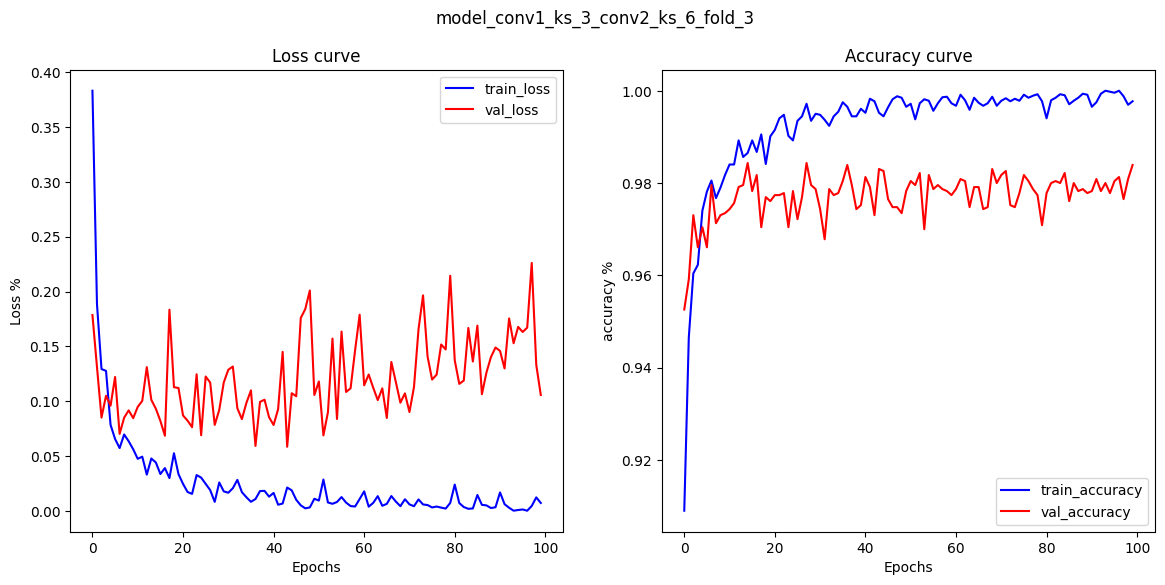



---- fold = 4 ---- conv1_ks = 3 ---- conv2_ks = 6-------

72/72 [==============================] - 0s 4ms/step - loss: 0.1279 - accuracy: 0.9817
conv1_ks=3,conv2_ks=6 Fold = 4 accuracy: 0.9817391037940979


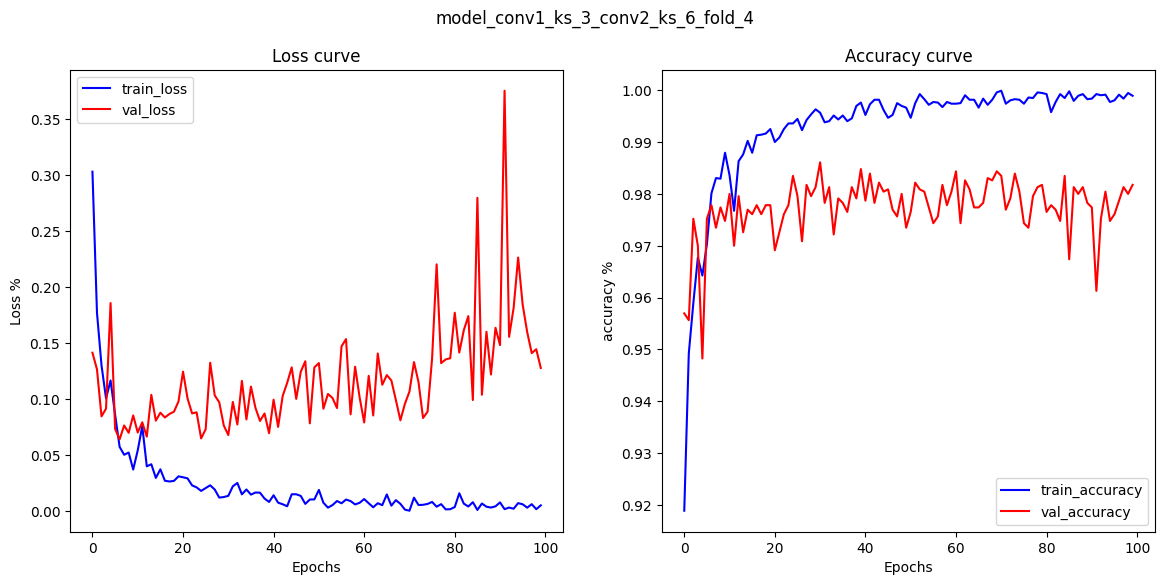



---- fold = 5 ---- conv1_ks = 3 ---- conv2_ks = 6-------

72/72 [==============================] - 0s 4ms/step - loss: 0.4829 - accuracy: 0.9552
conv1_ks=3,conv2_ks=6 Fold = 5 accuracy: 0.9552174210548401


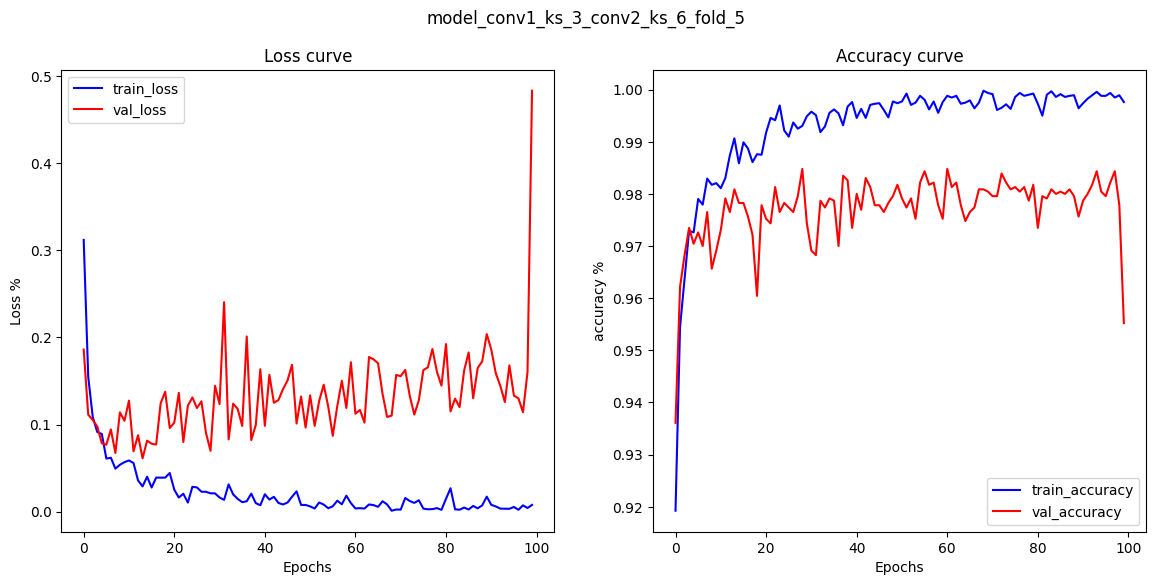

Mean Accuracy: 0.9740869641304016


---- fold = 1 ---- conv1_ks = 4 ---- conv2_ks = 3-------

72/72 [==============================] - 0s 5ms/step - loss: 0.1402 - accuracy: 0.9800
conv1_ks=4,conv2_ks=3 Fold = 1 accuracy: 0.9800000190734863


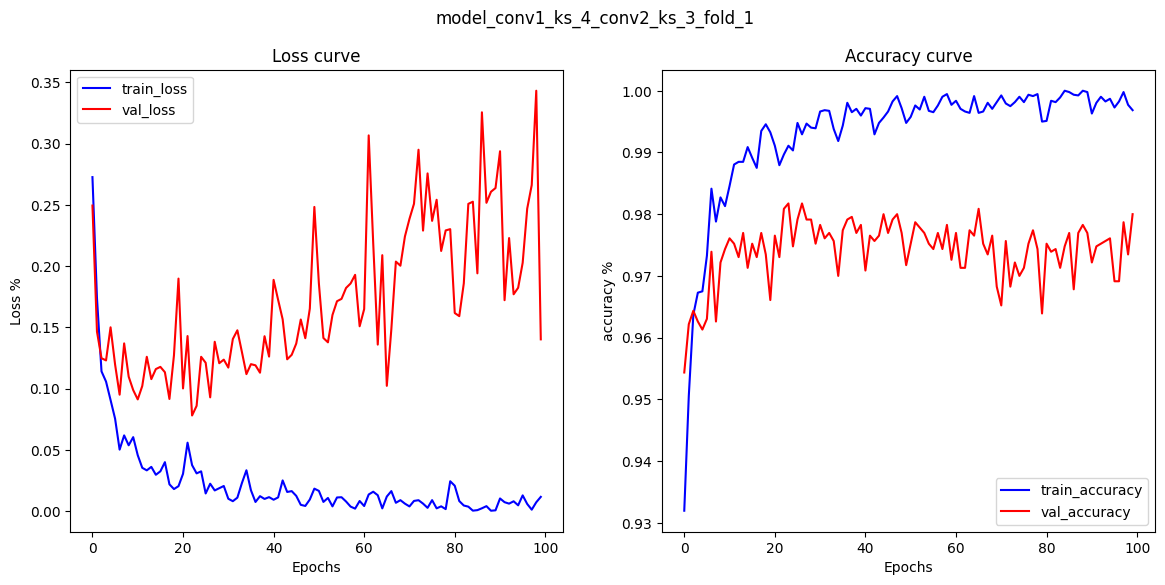



---- fold = 2 ---- conv1_ks = 4 ---- conv2_ks = 3-------

72/72 [==============================] - 0s 5ms/step - loss: 0.1397 - accuracy: 0.9752
conv1_ks=4,conv2_ks=3 Fold = 2 accuracy: 0.9752174019813538


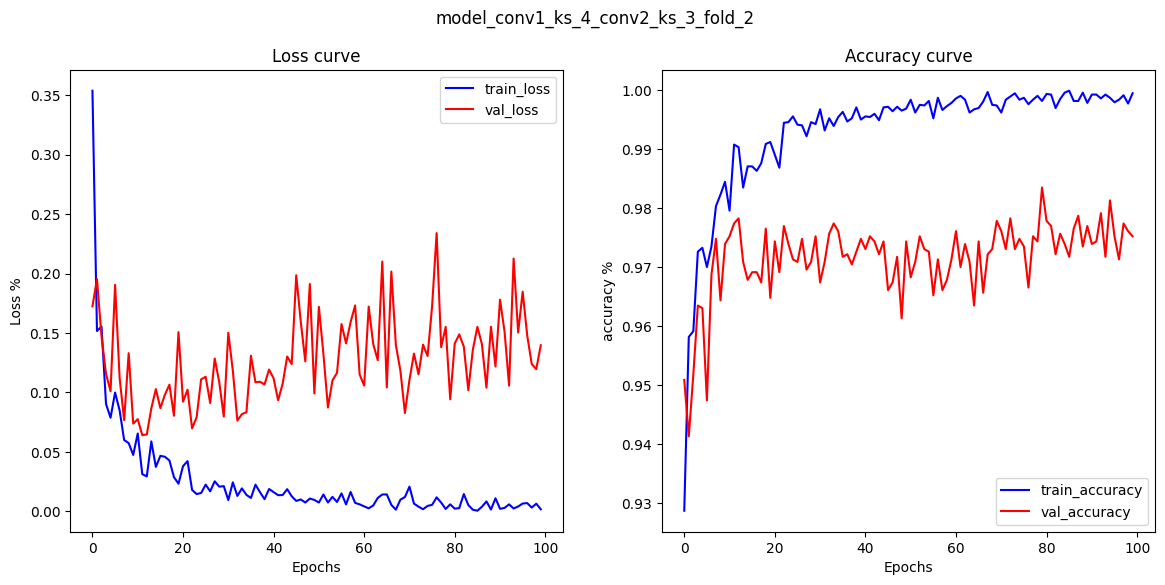



---- fold = 3 ---- conv1_ks = 4 ---- conv2_ks = 3-------

72/72 [==============================] - 0s 5ms/step - loss: 0.1604 - accuracy: 0.9765
conv1_ks=4,conv2_ks=3 Fold = 3 accuracy: 0.9765217304229736


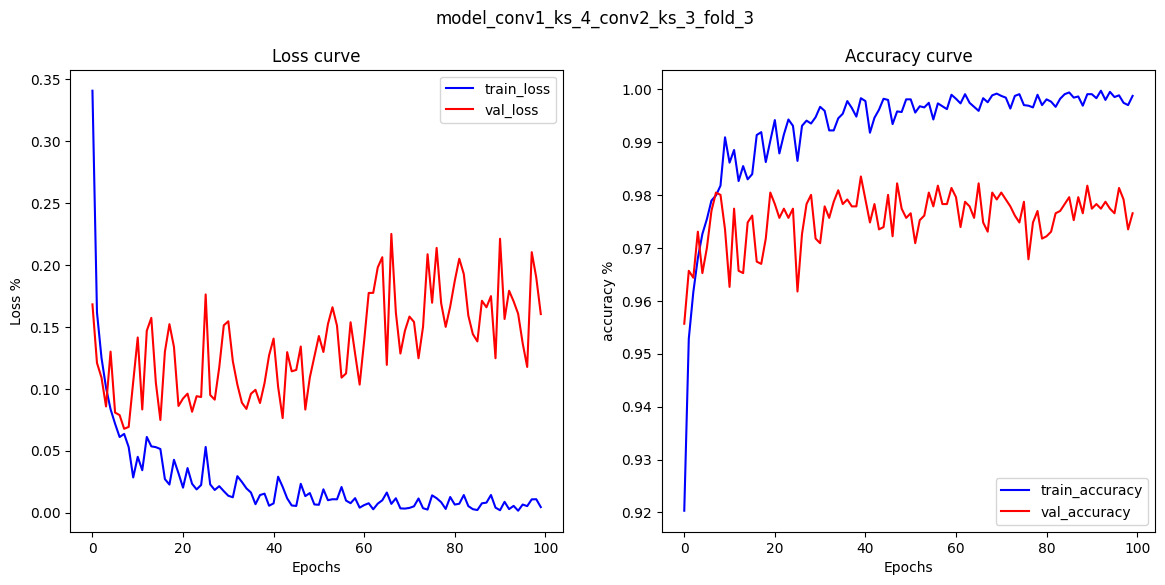



---- fold = 4 ---- conv1_ks = 4 ---- conv2_ks = 3-------

72/72 [==============================] - 0s 4ms/step - loss: 0.1117 - accuracy: 0.9839
conv1_ks=4,conv2_ks=3 Fold = 4 accuracy: 0.9839130640029907


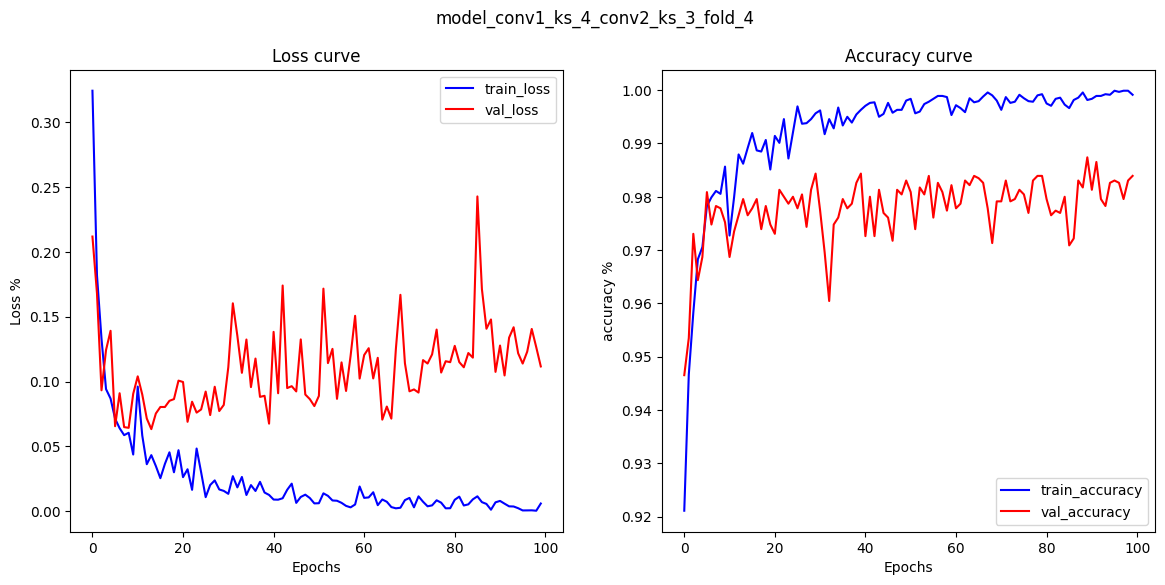



---- fold = 5 ---- conv1_ks = 4 ---- conv2_ks = 3-------

72/72 [==============================] - 0s 5ms/step - loss: 0.1163 - accuracy: 0.9830
conv1_ks=4,conv2_ks=3 Fold = 5 accuracy: 0.9830434918403625


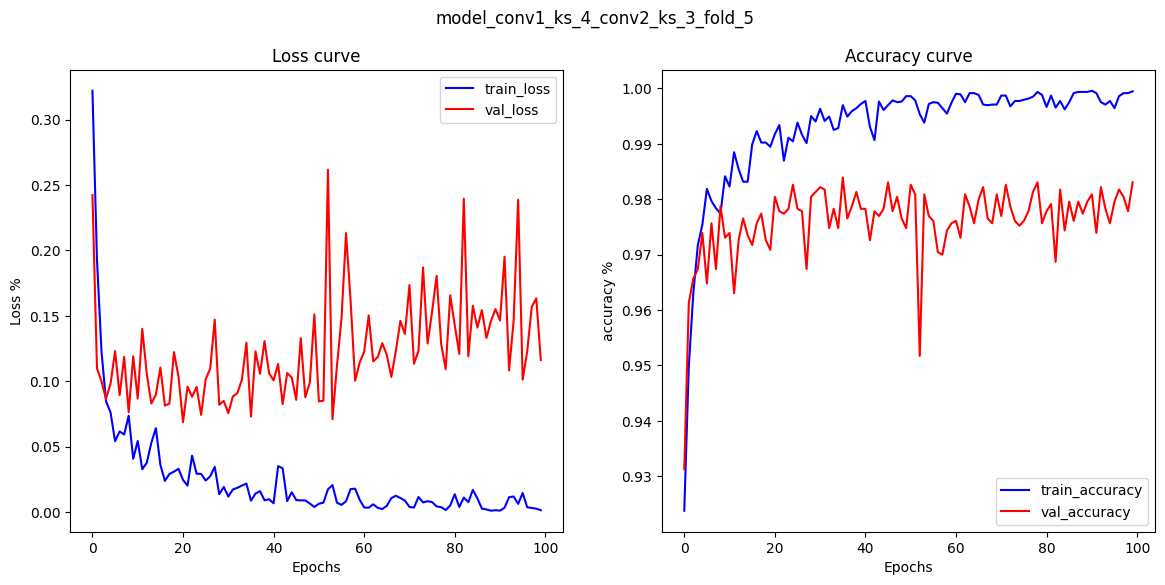

Mean Accuracy: 0.9797391414642334


---- fold = 1 ---- conv1_ks = 4 ---- conv2_ks = 4-------

72/72 [==============================] - 0s 5ms/step - loss: 0.1994 - accuracy: 0.9787
conv1_ks=4,conv2_ks=4 Fold = 1 accuracy: 0.9786956310272217


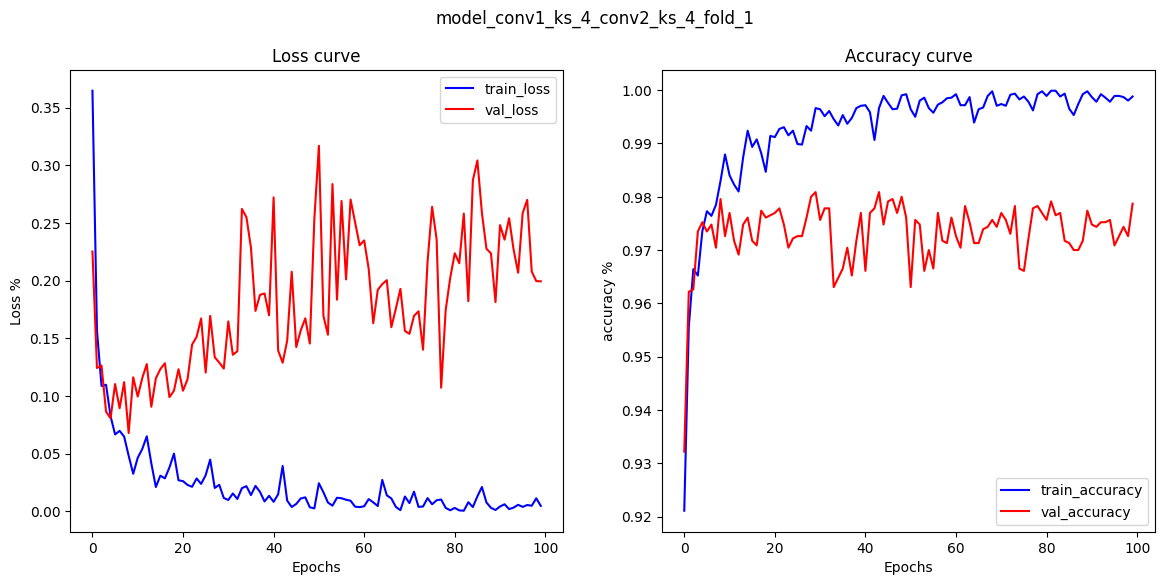



---- fold = 2 ---- conv1_ks = 4 ---- conv2_ks = 4-------

72/72 [==============================] - 0s 5ms/step - loss: 0.3018 - accuracy: 0.9722
conv1_ks=4,conv2_ks=4 Fold = 2 accuracy: 0.9721739292144775


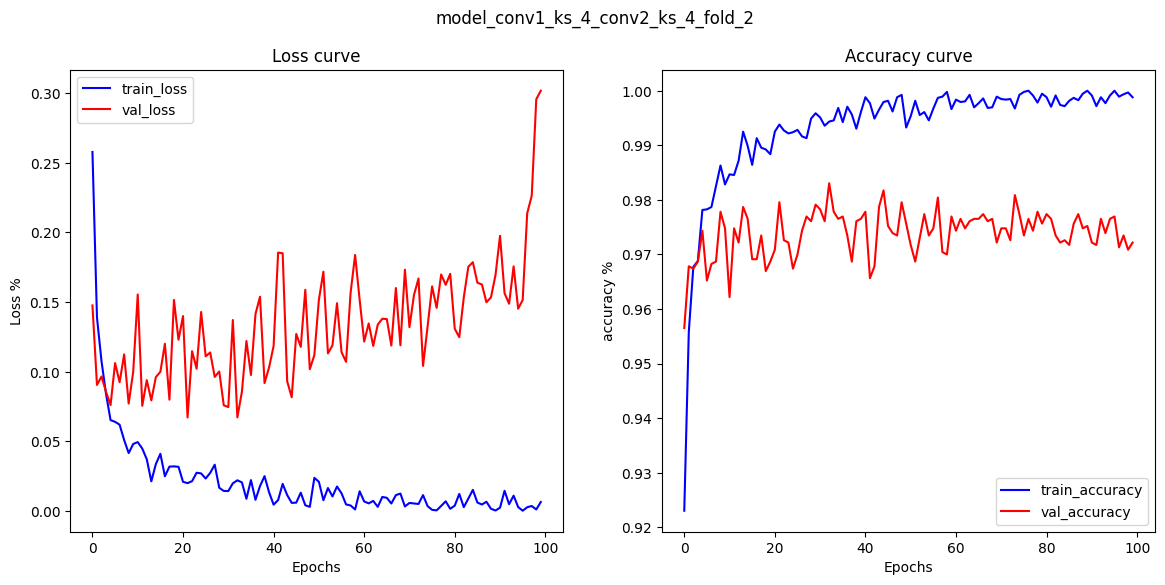



---- fold = 3 ---- conv1_ks = 4 ---- conv2_ks = 4-------

72/72 [==============================] - 0s 5ms/step - loss: 0.1865 - accuracy: 0.9778
conv1_ks=4,conv2_ks=4 Fold = 3 accuracy: 0.9778260588645935


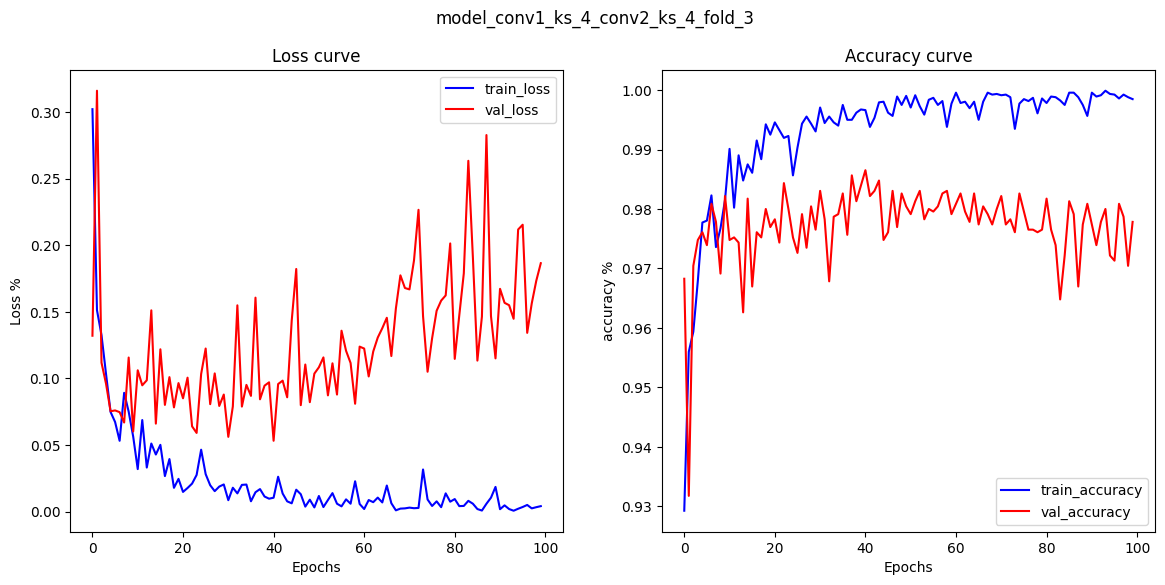



---- fold = 4 ---- conv1_ks = 4 ---- conv2_ks = 4-------



In [ ]:
kernel_sizes = [3, 4, 5, 6]

all_ks_history = []
all_ks_models = []

for ks_1 in kernel_sizes:
    for ks_2 in kernel_sizes:

        # Perform cross-validation
        fold_accuracy = []
        fold = 1

        for train_index, val_index in skf.split(X, y):
            X_train, X_val, y_train, y_val, input_shape = process_input(X, y, train_index, val_index)


            # model = eegClassifier(input_shape, ks_1, ks_2)
            model = create_sequential_eeg_model(input_shape, ks_1, ks_2)
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            log_file = f"model_ks1_{ks_1}_ks2_{ks_2}_fold_{fold}.log"
            model_name = f"model_ks1_{ks_1}_ks2_{ks_2}_fold_{fold}.h5"

            # Clear existing log handlers and close log files
            root_logger = logging.getLogger()
            for handler in root_logger.handlers:
                handler.close()
            root_logger.handlers.clear()

            # Create a separate log file for each model
            logger = init_logger(log_file, stdout=False)


            logger.info(f"\n\n---- fold = {fold} ---- conv1_ks = {ks_1} ---- conv2_ks = {ks_2}-------\n")
            print(f"\n\n---- fold = {fold} ---- conv1_ks = {ks_1} ---- conv2_ks = {ks_2}-------\n")

            # Define the checkpoint callback to save the best model
            checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', save_format="h5")

            # Train the model and capture the history
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,
                                callbacks=[checkpoint], verbose=0)

            # Log loss and accuracy
            for i, (loss, accuracy) in enumerate(zip(history.history['loss'], history.history['accuracy'])):
                logger.info(f"Epoch {i+1} - Loss: {loss} - Accuracy: {accuracy}")
            for i, (val_loss, val_accuracy) in enumerate(zip(history.history['val_loss'], history.history['val_accuracy'])):
                logger.info(f"Epoch {i+1} - Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}")


            # Evaluate the model on the test set
            loss_scale_optimizer, accuracy = model.evaluate(X_val, y_val)
            fold_accuracy.append(accuracy)

            # Log fold accuracy
            logger.info(f"conv1_ks={ks_1},conv2_ks={ks_2} Fold = {fold} accuracy: {accuracy}")

            print(f"conv1_ks={ks_1},conv2_ks={ks_2} Fold = {fold} accuracy: {accuracy}")
            plot_loss_accuracy(history, f"model_conv1_ks_{ks_1}_conv2_ks_{ks_2}_fold_{fold}")
            # plot_accuracy(history)

            fold += 1

        # Calculate the average accuracy across all folds
        mean_accuracy = np.mean(fold_accuracy)
        print("Mean Accuracy:", mean_accuracy)